# Bible Audio Acoustic Tokenization - Results Analysis

This notebook analyzes the results from the acoustic tokenization pipeline:
- **Phase 1**: Acoustic unit discovery using XLSR-53 + K-Means clustering
- **Phase 2**: BPE tokenizer training to discover acoustic motifs/patterns

## Dataset
- **Source**: Portuguese Bible audio (Old and New Testament)
- **Total segments**: 18,072 audio segments
- **Total audio**: ~5,057 minutes (~84 hours)
- **Acoustic units**: 100 units discovered via K-Means
- **BPE vocabulary**: 100 motifs discovered

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import sentencepiece as spm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Base directory for downloaded files
BASE_DIR = Path("./modal_downloads")
PHASE1_DIR = BASE_DIR / "phase1_outputs"
PHASE2_DIR = BASE_DIR / "phase2_outputs"
CHECKING_DIR = BASE_DIR / "checking_outputs"

print("📊 Analysis Notebook - Bible Audio Acoustic Tokenization")
print("=" * 60)
print(f"✓ Base directory: {BASE_DIR}")
print(f"✓ Phase 1 outputs: {PHASE1_DIR.exists()}")
print(f"✓ Phase 2 outputs: {PHASE2_DIR.exists()}")
print(f"✓ Checking outputs: {CHECKING_DIR.exists()}")

📊 Analysis Notebook - Bible Audio Acoustic Tokenization
✓ Base directory: modal_downloads
✓ Phase 1 outputs: True
✓ Phase 2 outputs: True
✓ Checking outputs: True


## 1. Motif Analysis (BPE Discovered Patterns)

The BPE tokenizer discovered 100 acoustic motifs - recurring patterns in the acoustic unit sequences. These motifs represent common sound patterns in Portuguese speech.

In [2]:
# Load motif analysis
with open(PHASE2_DIR / "motif_analysis.json", 'r') as f:
    motif_data = json.load(f)

print("🎵 Motif Analysis Results")
print("=" * 60)
print(f"Total tokens analyzed: {motif_data['total_tokens']:,}")
print(f"Unique motifs discovered: {motif_data['unique_motifs']}")
print(f"\nTop 20 Motifs by Frequency:")
print("-" * 60)

top_motifs = motif_data['top_motifs'][:20]
for i, item in enumerate(top_motifs, 1):
    motif = item['motif']
    count = item['count']
    percentage = (count / motif_data['total_tokens']) * 100
    # Count units in motif (remove BPE prefix ▁ and count space-separated units)
    units_in_motif = len([u for u in motif.replace("▁", "").strip().split() if u])
    print(f"{i:2d}. {motif:30s} | Count: {count:8,} ({percentage:5.2f}%) | Units: {units_in_motif}")

🎵 Motif Analysis Results
Total tokens analyzed: 15,158,934
Unique motifs discovered: 100

Top 20 Motifs by Frequency:
------------------------------------------------------------
 1. ▁65                            | Count:  318,460 ( 2.10%) | Units: 1
 2. ▁58                            | Count:  304,876 ( 2.01%) | Units: 1
 3. ▁3                             | Count:  289,313 ( 1.91%) | Units: 1
 4. ▁84                            | Count:  286,648 ( 1.89%) | Units: 1
 5. ▁54                            | Count:  276,372 ( 1.82%) | Units: 1
 6. ▁20                            | Count:  263,097 ( 1.74%) | Units: 1
 7. ▁41                            | Count:  253,421 ( 1.67%) | Units: 1
 8. ▁75                            | Count:  250,111 ( 1.65%) | Units: 1
 9. ▁22                            | Count:  247,949 ( 1.64%) | Units: 1
10. ▁5                             | Count:  233,387 ( 1.54%) | Units: 1
11. ▁15                            | Count:  227,492 ( 1.50%) | Units: 1
12. ▁43           

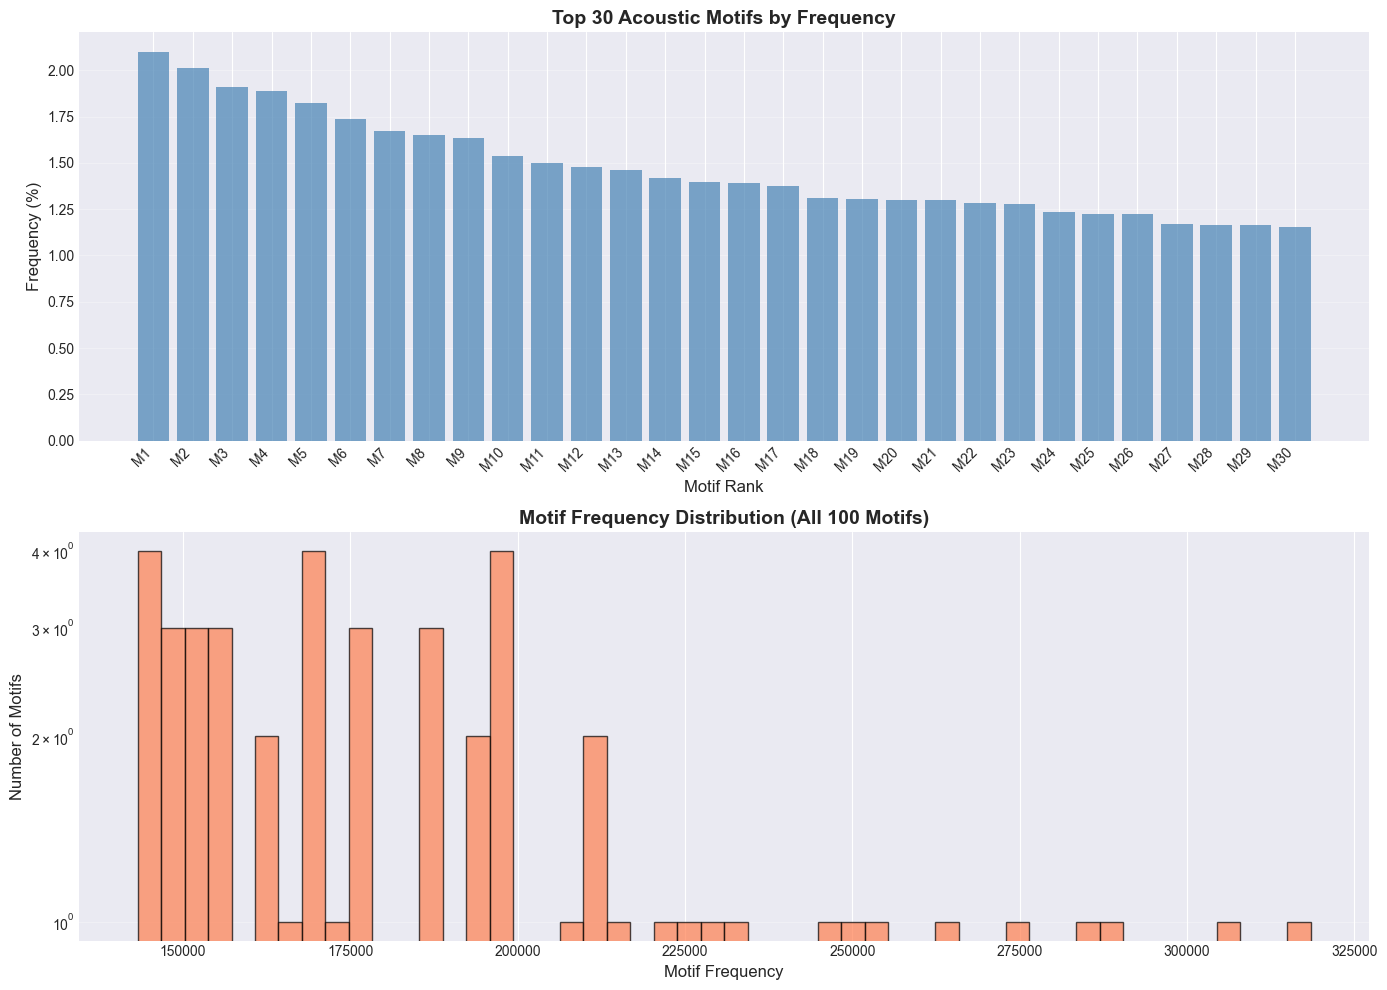


📈 Statistics:
   Most frequent motif: 2.10% of all tokens
   Top 10 motifs cover: 17.97% of all tokens
   Top 20 motifs cover: 31.90% of all tokens
   Top 50 motifs cover: 64.68% of all tokens


In [3]:
# Visualize motif frequency distribution
motif_counts = [m['count'] for m in motif_data['top_motifs']]
motif_percentages = [(c / motif_data['total_tokens']) * 100 for c in motif_counts]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 30 motifs bar chart
top_n = 30
axes[0].bar(range(top_n), motif_percentages[:top_n], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Motif Rank', fontsize=12)
axes[0].set_ylabel('Frequency (%)', fontsize=12)
axes[0].set_title(f'Top {top_n} Acoustic Motifs by Frequency', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(top_n))
axes[0].set_xticklabels([f"M{i+1}" for i in range(top_n)], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Frequency distribution (log scale)
axes[1].hist(motif_counts, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Motif Frequency', fontsize=12)
axes[1].set_ylabel('Number of Motifs', fontsize=12)
axes[1].set_title('Motif Frequency Distribution (All 100 Motifs)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Statistics:")
print(f"   Most frequent motif: {motif_percentages[0]:.2f}% of all tokens")
print(f"   Top 10 motifs cover: {sum(motif_percentages[:10]):.2f}% of all tokens")
print(f"   Top 20 motifs cover: {sum(motif_percentages[:20]):.2f}% of all tokens")
print(f"   Top 50 motifs cover: {sum(motif_percentages[:50]):.2f}% of all tokens")

## 2. BPE Vocabulary Analysis

Let's examine the BPE vocabulary file to see the discovered tokens.

In [4]:
# Load BPE vocabulary
vocab_path = PHASE2_DIR / "portuguese_bpe.vocab"

print("📚 BPE Vocabulary")
print("=" * 60)

vocab_lines = []
with open(vocab_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            vocab_lines.append(line.strip())

print(f"Total vocabulary entries: {len(vocab_lines)}")
print(f"\nFirst 20 vocabulary entries:")
print("-" * 60)
for i, entry in enumerate(vocab_lines[:20], 1):
    print(f"{i:2d}. {entry}")

# Load BPE model to get more details
try:
    sp = spm.SentencePieceProcessor()
    sp.load(str(PHASE2_DIR / "portuguese_bpe.model"))
    print(f"\n✓ BPE Model loaded successfully")
    print(f"   Vocabulary size: {sp.get_piece_size()}")
    print(f"\nSample tokens:")
    for i in range(min(10, sp.get_piece_size())):
        token = sp.id_to_piece(i)
        print(f"   {i:3d}: {token}")
except Exception as e:
    print(f"⚠️  Could not load BPE model: {e}")

📚 BPE Vocabulary
Total vocabulary entries: 450

First 20 vocabulary entries:
------------------------------------------------------------
 1. <unk>	0
 2. <s>	0
 3. </s>	0
 4. <0x00>	0
 5. <0x01>	0
 6. <0x02>	0
 7. <0x03>	0
 8. <0x04>	0
 9. <0x05>	0
10. <0x06>	0
11. <0x07>	0
12. <0x08>	0
13. <0x09>	0
14. <0x0A>	0
15. <0x0B>	0
16. <0x0C>	0
17. <0x0D>	0
18. <0x0E>	0
19. <0x0F>	0
20. <0x10>	0

✓ BPE Model loaded successfully
   Vocabulary size: 450

Sample tokens:
     0: <unk>
     1: <s>
     2: </s>
     3: <0x00>
     4: <0x01>
     5: <0x02>
     6: <0x03>
     7: <0x04>
     8: <0x05>
     9: <0x06>


## 3. Acoustic Unit Statistics

Analysis of the 100 acoustic units discovered via K-Means clustering.

In [5]:
# Load validation results
with open(CHECKING_DIR / "validation_results.json", 'r') as f:
    validation = json.load(f)

print("🔍 Acoustic Unit Validation")
print("=" * 60)
stats = validation['unit_stats']
print(f"Total units in sample: {stats['total_units']:,}")
print(f"Unique units found: {stats['unique_units']}/{stats['expected_unique']}")
print(f"Unit ID range: {stats['unit_range'][0]} - {stats['unit_range'][1]}")
print(f"Average sequence length: {stats['avg_sequence_length']:.1f} units")
print(f"Min sequence length: {stats['min_sequence_length']} units")
print(f"Max sequence length: {stats['max_sequence_length']} units")
print(f"Total sequences analyzed: {validation['total_sequences']}")

🔍 Acoustic Unit Validation
Total units in sample: 7,788
Unique units found: 100/100
Unit ID range: 0 - 99
Average sequence length: 778.8 units
Min sequence length: 136 units
Max sequence length: 1656 units
Total sequences analyzed: 10



📝 Sample Unit Sequence Analysis
File: 🔴 ÊXODO 📖 (a Saída de Israel do Egito) Bíblia Narrada Completa - SHEMOT_seg_1164.units.txt
Sequence length: 2513 units
First 50 units: [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 38, 87, 3, 4, 4, 4, 4, 74, 81, 95, 34, 34, 29, 63, 22, 22, 54, 32, 32, 32, 25, 25, 25, 72, 37, 37, 43, 5, 5, 39, 81, 6, 6, 6, 6, 6, 6]
Last 50 units: [69, 21, 69, 69, 69, 69, 69, 33, 69, 69, 69, 69, 31, 21, 31, 31, 31, 31, 31, 31, 31, 31, 31, 12, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 50, 46, 31]

Most frequent units in this sequence:
   Unit   6:   72 times (2.9%)
   Unit  58:   68 times (2.7%)
   Unit  54:   58 times (2.3%)
   Unit  41:   55 times (2.2%)
   Unit  96:   54 times (2.1%)
   Unit  32:   53 times (2.1%)
   Unit   0:   48 times (1.9%)
   Unit  92:   46 times (1.8%)
   Unit  14:   45 times (1.8%)
   Unit   3:   44 times (1.8%)


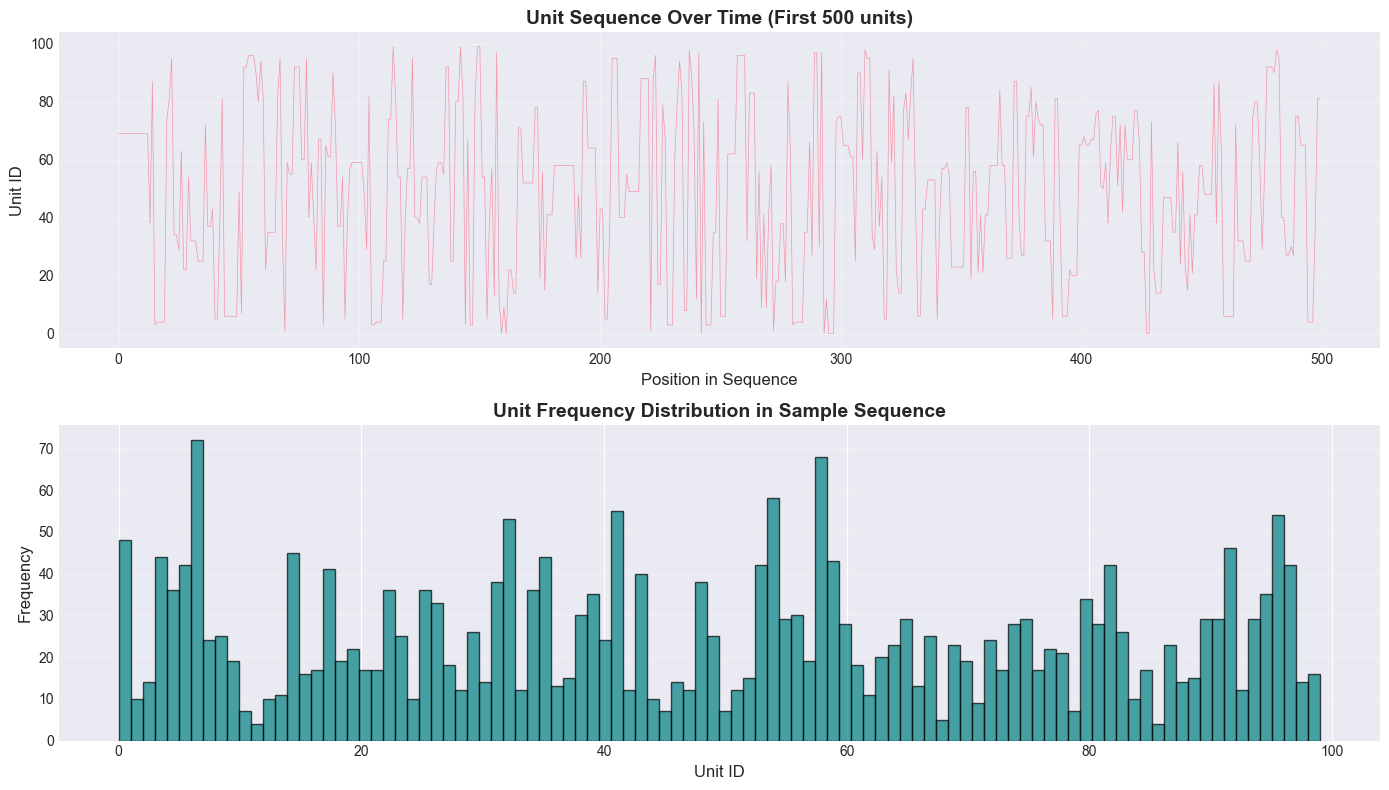

In [6]:
# Load a sample unit sequence
sample_unit_files = list((BASE_DIR / "sample_units").glob("*.units.txt"))
if sample_unit_files:
    sample_unit_file = sample_unit_files[0]
    with open(sample_unit_file, 'r') as f:
        sample_units = [int(u) for u in f.read().strip().split()]
    
    print(f"\n📝 Sample Unit Sequence Analysis")
    print("=" * 60)
    print(f"File: {sample_unit_file.name}")
    print(f"Sequence length: {len(sample_units)} units")
    print(f"First 50 units: {sample_units[:50]}")
    print(f"Last 50 units: {sample_units[-50:]}")
    
    # Unit frequency in this sequence
    unit_freq = Counter(sample_units)
    print(f"\nMost frequent units in this sequence:")
    for unit, count in unit_freq.most_common(10):
        print(f"   Unit {unit:3d}: {count:4d} times ({count/len(sample_units)*100:.1f}%)")
    
    # Visualize unit distribution
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Unit sequence over time
    axes[0].plot(sample_units[:500], alpha=0.7, linewidth=0.5)
    axes[0].set_xlabel('Position in Sequence', fontsize=12)
    axes[0].set_ylabel('Unit ID', fontsize=12)
    axes[0].set_title('Unit Sequence Over Time (First 500 units)', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Unit frequency histogram
    axes[1].hist(sample_units, bins=100, color='teal', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Unit ID', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Unit Frequency Distribution in Sample Sequence', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Sample unit file not found")

## 5. Audio Playback & Analysis

Listen to sample audio segments and analyze their acoustic properties.

🎵 Audio Playback & Analysis
Loading: Livro de JÓ - A paciência de JÓ e a Presença de DEUS_seg_0396.wav

📊 Audio Properties:
   Sample rate: 16000 Hz
   Duration: 24.68 seconds
   Samples: 394,880
   Data type: float64
   Min/Max amplitude: -1.0000 / 1.0000

🔊 Play Audio:


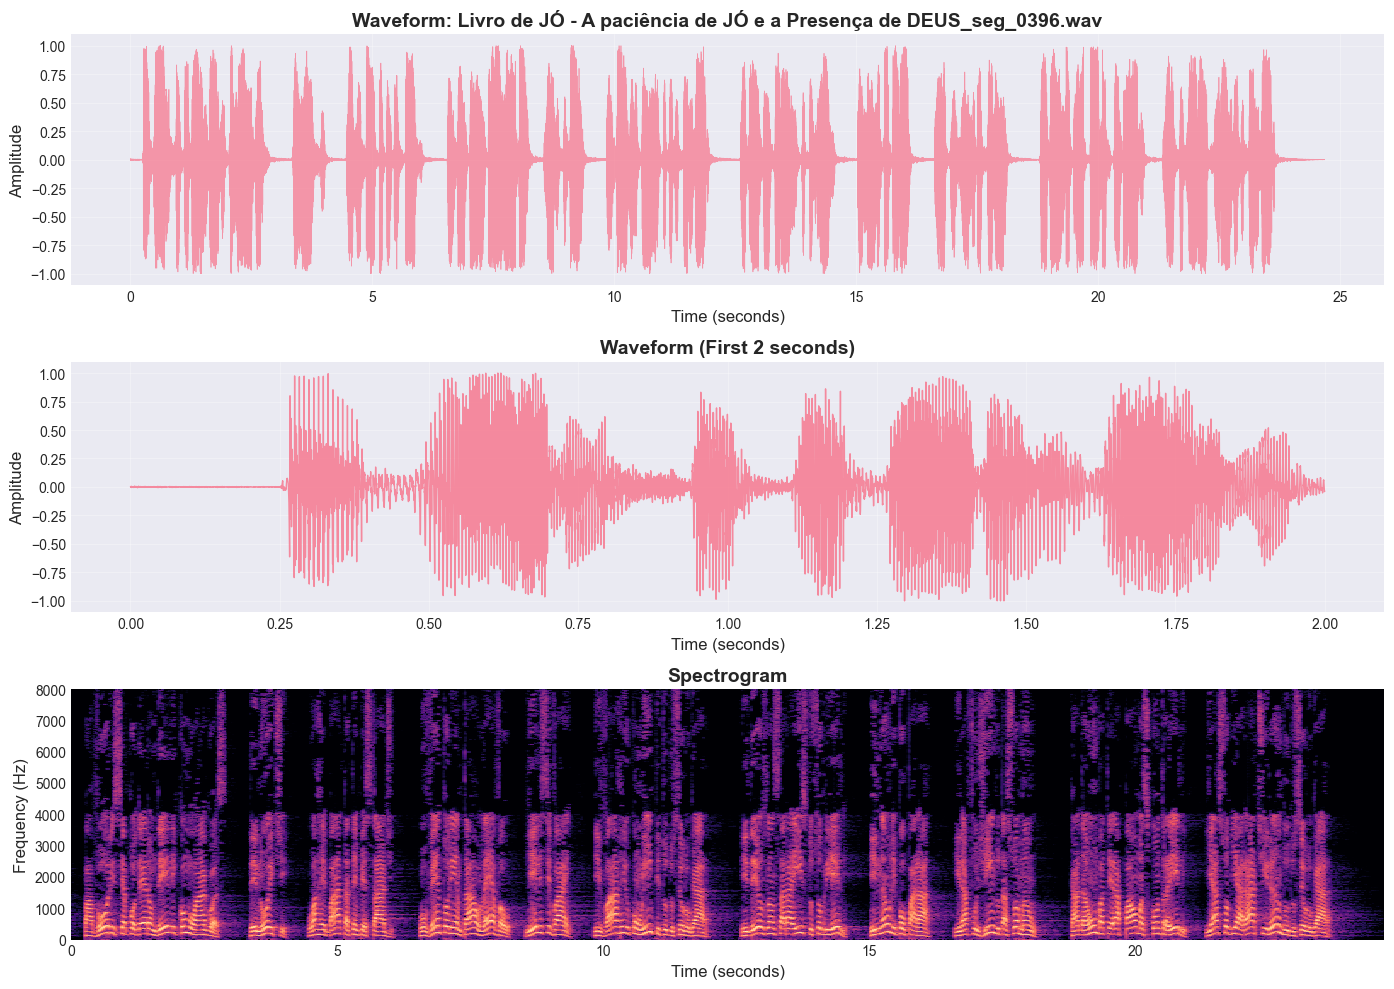


📈 Audio Statistics:
   RMS Energy: 0.2509
   Zero Crossing Rate: 1424.88 crossings/second
   Dynamic Range: 2.0000


In [7]:
# Load and play sample audio
import soundfile as sf
import librosa
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np

print("🎵 Audio Playback & Analysis")
print("=" * 60)

# Find sample audio files
sample_audio_dir = BASE_DIR / "sample_audio"
audio_files = list(sample_audio_dir.glob("*.wav"))

if audio_files:
    audio_file = audio_files[0]
    print(f"Loading: {audio_file.name}")
    
    # Load audio
    audio_data, sample_rate = sf.read(str(audio_file))
    
    # Convert to mono if stereo
    if len(audio_data.shape) > 1:
        audio_data = audio_data.mean(axis=1)
    
    duration = len(audio_data) / sample_rate
    
    print(f"\n📊 Audio Properties:")
    print(f"   Sample rate: {sample_rate} Hz")
    print(f"   Duration: {duration:.2f} seconds")
    print(f"   Samples: {len(audio_data):,}")
    print(f"   Data type: {audio_data.dtype}")
    print(f"   Min/Max amplitude: {audio_data.min():.4f} / {audio_data.max():.4f}")
    
    # Play audio in notebook
    print(f"\n🔊 Play Audio:")
    display(Audio(audio_data, rate=sample_rate))
    
    # Visualize waveform
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Full waveform
    time_axis = np.linspace(0, duration, len(audio_data))
    axes[0].plot(time_axis, audio_data, alpha=0.7, linewidth=0.5)
    axes[0].set_xlabel('Time (seconds)', fontsize=12)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].set_title(f'Waveform: {audio_file.name}', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # First 2 seconds zoom
    zoom_samples = int(2 * sample_rate)
    if len(audio_data) > zoom_samples:
        axes[1].plot(time_axis[:zoom_samples], audio_data[:zoom_samples], alpha=0.8, linewidth=1)
        axes[1].set_xlabel('Time (seconds)', fontsize=12)
        axes[1].set_ylabel('Amplitude', fontsize=12)
        axes[1].set_title('Waveform (First 2 seconds)', fontsize=14, fontweight='bold')
        axes[1].grid(alpha=0.3)
    
    # Spectrogram
    try:
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
        librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sample_rate, ax=axes[2])
        axes[2].set_title('Spectrogram', fontsize=14, fontweight='bold')
        axes[2].set_ylabel('Frequency (Hz)', fontsize=12)
        axes[2].set_xlabel('Time (seconds)', fontsize=12)
    except Exception as e:
        axes[2].text(0.5, 0.5, f'Could not generate spectrogram: {e}', 
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Spectrogram (Error)', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Audio statistics
    print(f"\n📈 Audio Statistics:")
    rms_energy = np.sqrt(np.mean(audio_data**2))
    zero_crossings = librosa.zero_crossings(audio_data, pad=False).sum()
    zcr = zero_crossings / len(audio_data) * sample_rate
    
    print(f"   RMS Energy: {rms_energy:.4f}")
    print(f"   Zero Crossing Rate: {zcr:.2f} crossings/second")
    print(f"   Dynamic Range: {audio_data.max() - audio_data.min():.4f}")
    
else:
    print("⚠️  No sample audio files found in sample_audio/ directory")

🔗 Audio-Unit Correspondence
Audio: Livro de JÓ - A paciência de JÓ e a Presença de DEUS_seg_0396.wav
Units: 🔴 ÊXODO 📖 (a Saída de Israel do Egito) Bíblia Narrada Completa - SHEMOT_seg_1164.units.txt

📊 Correspondence:
   Audio duration: 24.68 seconds
   Number of units: 2513
   Units per second: 101.82
   Samples per unit: 157.1
   Unit frame rate: ~9.8 ms per unit


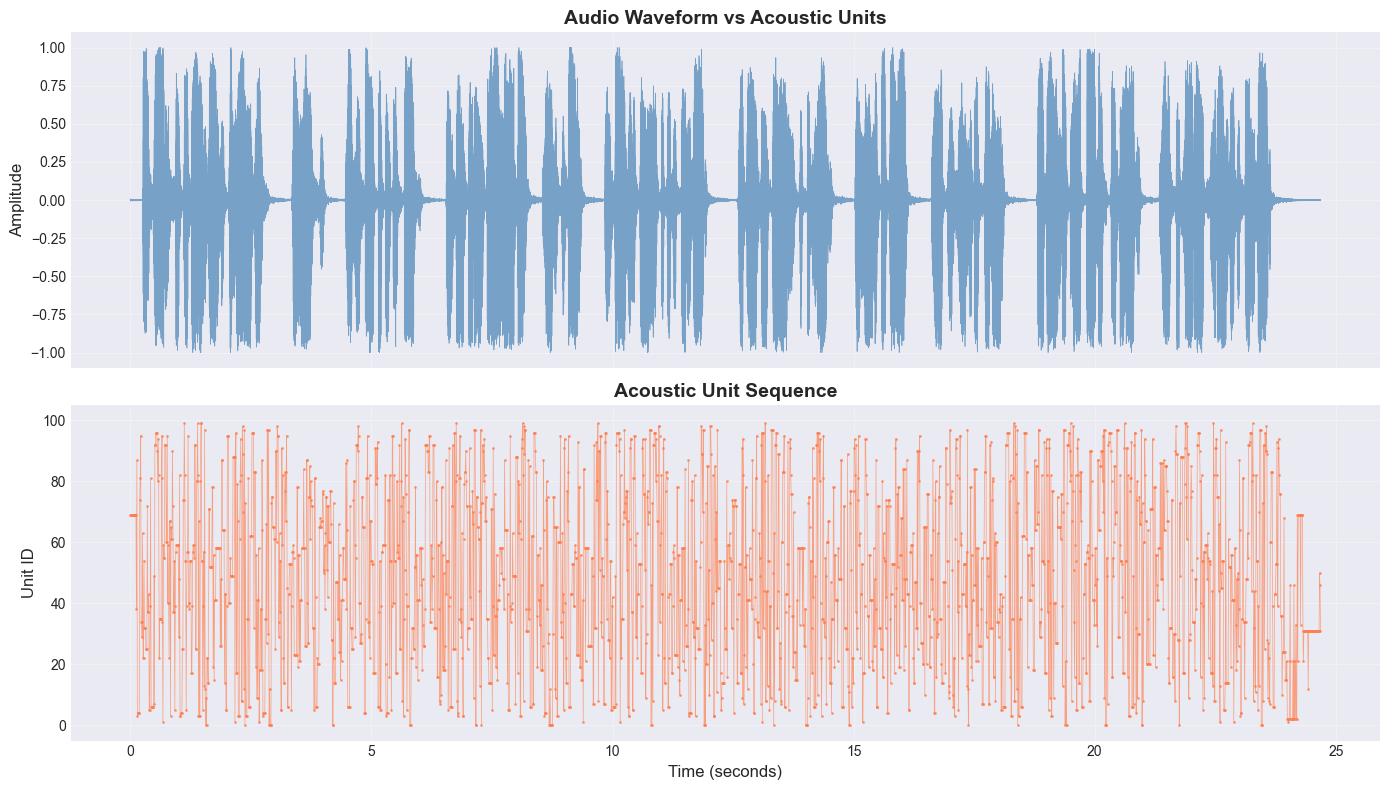

In [8]:
# Compare audio with its corresponding unit sequence
print("🔗 Audio-Unit Correspondence")
print("=" * 60)

# Find matching unit file
sample_unit_files = list((BASE_DIR / "sample_units").glob("*.units.txt"))
if audio_files and sample_unit_files:
    # Try to match by name (simplified - just use first of each)
    audio_file = audio_files[0]
    unit_file = sample_unit_files[0]
    
    print(f"Audio: {audio_file.name}")
    print(f"Units: {unit_file.name}")
    
    # Load units
    with open(unit_file, 'r') as f:
        units = [int(u) for u in f.read().strip().split()]
    
    # Load audio
    audio_data, sample_rate = sf.read(str(audio_file))
    if len(audio_data.shape) > 1:
        audio_data = audio_data.mean(axis=1)
    
    duration = len(audio_data) / sample_rate
    
    # Calculate timing
    units_per_second = len(units) / duration
    samples_per_unit = len(audio_data) / len(units)
    
    print(f"\n📊 Correspondence:")
    print(f"   Audio duration: {duration:.2f} seconds")
    print(f"   Number of units: {len(units)}")
    print(f"   Units per second: {units_per_second:.2f}")
    print(f"   Samples per unit: {samples_per_unit:.1f}")
    print(f"   Unit frame rate: ~{1/units_per_second*1000:.1f} ms per unit")
    
    # Visualize alignment
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Audio waveform
    time_axis = np.linspace(0, duration, len(audio_data))
    axes[0].plot(time_axis, audio_data, alpha=0.7, linewidth=0.5, color='steelblue')
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].set_title('Audio Waveform vs Acoustic Units', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Unit sequence (scaled to match time)
    unit_time_axis = np.linspace(0, duration, len(units))
    axes[1].plot(unit_time_axis, units, alpha=0.7, linewidth=0.5, color='coral', marker='.', markersize=2)
    axes[1].set_xlabel('Time (seconds)', fontsize=12)
    axes[1].set_ylabel('Unit ID', fontsize=12)
    axes[1].set_title('Acoustic Unit Sequence', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim(-5, 105)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  Need both audio and unit files for comparison")

In [9]:
# Audio quality metrics (if we had synthesized audio to compare)
print("📏 Audio Quality Metrics")
print("=" * 60)

if audio_files:
    audio_file = audio_files[0]
    audio_data, sample_rate = sf.read(str(audio_file))
    if len(audio_data.shape) > 1:
        audio_data = audio_data.mean(axis=1)
    
    # Normalize
    audio_data = audio_data / np.max(np.abs(audio_data))
    
    # Calculate metrics
    metrics = {}
    
    # Signal-to-Noise Ratio (SNR) approximation
    signal_power = np.mean(audio_data**2)
    noise_estimate = np.std(audio_data - np.mean(audio_data))
    snr_db = 10 * np.log10(signal_power / (noise_estimate**2 + 1e-10))
    metrics['SNR_approx_db'] = snr_db
    
    # Spectral features
    try:
        spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
        # Take mean along time axis (axis=1) to get single value
        metrics['spectral_centroid_hz'] = float(np.mean(spectral_centroid))
        metrics['spectral_rolloff_hz'] = float(np.mean(spectral_rolloff))
        metrics['mfcc_mean'] = [float(np.mean(mfcc)) for mfcc in mfccs]
    except Exception as e:
        print(f"⚠️  Could not compute spectral features: {e}")
    
    # Energy features
    rms = librosa.feature.rms(y=audio_data)[0]
    metrics['rms_mean'] = float(np.mean(rms))
    metrics['rms_std'] = float(np.std(rms))
    
    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(audio_data)[0]
    metrics['zcr_mean'] = float(np.mean(zcr))
    
    print(f"\n📊 Computed Metrics:")
    # Helper function to format metrics safely
    def format_metric(value, format_str='.2f'):
        if value == 'N/A' or value is None:
            return 'N/A'
        try:
            return f"{value:{format_str}}"
        except:
            return str(value)
    
    print(f"   Approximate SNR: {format_metric(metrics.get('SNR_approx_db', 'N/A'), '.2f')} dB")
    print(f"   Spectral Centroid: {format_metric(metrics.get('spectral_centroid_hz', 'N/A'), '.1f')} Hz")
    print(f"   Spectral Rolloff: {format_metric(metrics.get('spectral_rolloff_hz', 'N/A'), '.1f')} Hz")
    print(f"   RMS Energy (mean): {format_metric(metrics.get('rms_mean', 'N/A'), '.4f')}")
    print(f"   Zero Crossing Rate: {format_metric(metrics.get('zcr_mean', 'N/A'), '.4f')}")
    
    print(f"\n💡 These metrics can be used to:")
    print(f"   • Compare original vs synthesized audio")
    print(f"   • Measure audio quality")
    print(f"   • Analyze acoustic characteristics")
    print(f"   • Validate unit-to-audio reconstruction")
    
else:
    print("⚠️  No audio files available for analysis")

📏 Audio Quality Metrics

📊 Computed Metrics:
   Approximate SNR: -0.00 dB
   Spectral Centroid: 1213.1 Hz
   Spectral Rolloff: 2260.8 Hz
   RMS Energy (mean): 0.2120
   Zero Crossing Rate: 0.0888

💡 These metrics can be used to:
   • Compare original vs synthesized audio
   • Measure audio quality
   • Analyze acoustic characteristics
   • Validate unit-to-audio reconstruction


## 6. Testing & Validation

Test the acoustic tokenization pipeline by comparing original audio with unit sequences.

In [10]:
# Test: Verify unit sequences match audio segments
print("🧪 Testing Pipeline Validation")
print("=" * 60)

# Check if we can load K-Means and reverse-engineer units
try:
    import joblib
    
    kmeans_path = PHASE1_DIR / "portuguese_kmeans.pkl"
    if kmeans_path.exists():
        kmeans = joblib.load(kmeans_path)
        print(f"✓ K-Means model loaded: {kmeans.n_clusters} clusters")
        
        # Test: Show cluster centers statistics
        centers = kmeans.cluster_centers_
        print(f"\n📊 Cluster Statistics:")
        print(f"   Number of clusters: {centers.shape[0]}")
        print(f"   Feature dimensions: {centers.shape[1]}")
        print(f"   Center value range: [{centers.min():.4f}, {centers.max():.4f}]")
        print(f"   Mean center norm: {np.mean([np.linalg.norm(c) for c in centers]):.4f}")
        
        # Test: Predict units from a sample
        if audio_files:
            audio_file = audio_files[0]
            print(f"\n🔍 Testing unit prediction on: {audio_file.name}")
            
            # This would require loading XLSR-53 model, so we'll skip full prediction
            # But we can verify the unit sequence format
            if sample_unit_files:
                unit_file = sample_unit_files[0]
                with open(unit_file, 'r') as f:
                    test_units = [int(u) for u in f.read().strip().split()]
                
                # Verify units are in valid range
                valid_units = [u for u in test_units if 0 <= u < kmeans.n_clusters]
                invalid_units = [u for u in test_units if u < 0 or u >= kmeans.n_clusters]
                
                print(f"   Total units: {len(test_units)}")
                print(f"   Valid units (0-{kmeans.n_clusters-1}): {len(valid_units)}")
                if invalid_units:
                    print(f"   ⚠️  Invalid units found: {len(invalid_units)}")
                else:
                    print(f"   ✓ All units are valid!")
                
                # Unit distribution
                unit_counts = Counter(test_units)
                print(f"\n   Most common units:")
                for unit, count in unit_counts.most_common(5):
                    print(f"      Unit {unit:3d}: {count:4d} times ({count/len(test_units)*100:.1f}%)")
        
    else:
        print("⚠️  K-Means model not found")
        
except Exception as e:
    print(f"⚠️  Error loading K-Means: {e}")
    import traceback
    traceback.print_exc()

print(f"\n✅ Validation complete!")

🧪 Testing Pipeline Validation
✓ K-Means model loaded: 100 clusters

📊 Cluster Statistics:
   Number of clusters: 100
   Feature dimensions: 1024
   Center value range: [-286.7044, 679.4097]
   Mean center norm: 145.2362

🔍 Testing unit prediction on: Livro de JÓ - A paciência de JÓ e a Presença de DEUS_seg_0396.wav
   Total units: 2513
   Valid units (0-99): 2513
   ✓ All units are valid!

   Most common units:
      Unit   6:   72 times (2.9%)
      Unit  58:   68 times (2.7%)
      Unit  54:   58 times (2.3%)
      Unit  41:   55 times (2.2%)
      Unit  96:   54 times (2.1%)

✅ Validation complete!


/Users/joao/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MiniBatchKMeans from version 1.8.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 4. Summary & Insights

Key findings from the acoustic tokenization pipeline.

In [11]:
# Calculate summary statistics
motif_counts = [m['count'] for m in motif_data['top_motifs']]
motif_percentages = [(c / motif_data['total_tokens']) * 100 for c in motif_counts]

print("📋 Summary & Key Insights")
print("=" * 60)
print("\n🎯 Pipeline Results:")
print(f"   • Processed {validation['total_sequences']:,} audio segments")
print(f"   • Discovered {motif_data['unique_motifs']} acoustic motifs via BPE")
print(f"   • Created {motif_data['total_tokens']:,} total tokens")
print(f"   • Average sequence length: {stats['avg_sequence_length']:.1f} units")

print("\n🔍 Acoustic Unit Discovery:")
print(f"   • K-Means clustering found {stats['expected_unique']} distinct acoustic units")
print(f"   • Units represent quantized acoustic features from XLSR-53 model")
print(f"   • Unit range: 0-{stats['unit_range'][1]} (covering all discovered units)")

print("\n🎵 Motif Discovery:")
print(f"   • Top motif frequency: {motif_percentages[0]:.2f}% of all tokens")
print(f"   • Top 10 motifs cover: {sum(motif_percentages[:10]):.2f}% of tokens")
print(f"   • Top 20 motifs cover: {sum(motif_percentages[:20]):.2f}% of tokens")
print(f"   • This indicates common acoustic patterns in Portuguese speech")

print("\n💡 Applications:")
print("   • Text-to-Speech synthesis using discovered units")
print("   • Speech recognition using acoustic motifs")
print("   • Language modeling for Portuguese audio")
print("   • Acoustic pattern analysis and research")

print("\n✅ Analysis Complete!")
print("=" * 60)

📋 Summary & Key Insights

🎯 Pipeline Results:
   • Processed 10 audio segments
   • Discovered 100 acoustic motifs via BPE
   • Created 15,158,934 total tokens
   • Average sequence length: 778.8 units

🔍 Acoustic Unit Discovery:
   • K-Means clustering found 100 distinct acoustic units
   • Units represent quantized acoustic features from XLSR-53 model
   • Unit range: 0-99 (covering all discovered units)

🎵 Motif Discovery:
   • Top motif frequency: 2.10% of all tokens
   • Top 10 motifs cover: 17.97% of tokens
   • Top 20 motifs cover: 31.90% of tokens
   • This indicates common acoustic patterns in Portuguese speech

💡 Applications:
   • Text-to-Speech synthesis using discovered units
   • Speech recognition using acoustic motifs
   • Language modeling for Portuguese audio
   • Acoustic pattern analysis and research

✅ Analysis Complete!
